# 3D EOF Computation
Program by: Danielle Lafarga\
email: dlafarga9505@sdsu.edu\
website:  https://dlafarga.github.io

In [2]:
import numpy as np

from numpy import meshgrid
import scipy.io as sc
import os
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from numpy import linspace
from numpy import meshgrid

# Read in data
You will need to do this on your own. Make sure the data is stored in an N by Y array named data_T where N is the total grid point and Y is the total time steps. 

## Compute Standard Deviation and Climatology

In [11]:
N = data_T.shape[0] # total number of points
Y = data_T.shape[1] # total number of years

np.nanmean and np.nanstd computes the average and standard deviation for the rows (hence axis = 1) of the data. The command takes into account the NaNs for the data

In [12]:
import warnings

# I expect to see RuntimeWarnings in this block

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    clim = np.nanmean(data_T, axis = 1)   # climatology  
    sdev = np.nanstd(data_T, axis = 1)    # standard deviation
clim_sdev = np.column_stack((clim, sdev)) # save this as one matrix 

## Compute anomalies

Details of computing anomalies is in this post https://dlafarga.github.io/journal/Covarianceintime.html


In [13]:
anom = data_T - clim
anom.shape

(2073600, 54)

# Calc Standardized Anom

Standardized anomalies are anomalies divided by standard deviation

In [14]:
np.seterr(divide='ignore', invalid='ignore') # runtime error will appear because of truncation
stnd_anom = anom/sdev

## Compute area weighted Anom

Each Anom has to be multiplied by a weight to project data onto a physical surface. This weight takes into account lattitude and thickness of depth. 
$ weight = \sqrt{cos(\phi) \Delta z}$

where:

$\phi = \frac{lattitude\times\pi}{180}$

and

$\Delta z$ is the change in depth

In [15]:
import math

In [16]:
# formating lattitude values for area weight
x = linspace(0, 360, 360) # Longitutde values
y = linspace(-90, 90, 180) # Latitude values

xx, yy = meshgrid(x, y)

yy = yy.transpose()
y_temp = yy.flatten()

In [19]:
# area weight for lattitude values
lat_w = np.cos(y_temp*math.pi/180)

In [20]:
# area weights for depth
area_weight = []

for i in range(tot_depths):
    if i == 0:
        area_weight.append(np.sqrt(5 * lat_w)) # first depth thickness is just 0-5m
    else:
        area_weight.append( np.sqrt((depths[i] - depths[i - 1]) * lat_w))

In [23]:
# Turning weights into one array
area_weight = np.mat(area_weight)
area_weight = area_weight.flatten()
area_weight = area_weight.transpose()

(2073600, 1)

In [26]:
weighted_A = np.empty((N,Y)) * np.nan
weighted_A = np.multiply(anom , area_weight)
weighted_A.shape

(2073600, 54)

## Getting rid of NaN in anom

NaN needs to be removed from the data to compute covariance, eigenvalues, and eigenvectors

In [37]:
# find which indicies have data (are not NaN)
numrows = np.argwhere(np.isnan(weighted_A[:,0]) == False)
new_N = round(numrows .shape[0])

In [38]:
# Create matrix with only values
new_anom = np.empty((new_N,Y)) * np.nan
for i in range(new_N):
        new_anom[i,:] = weighted_A[numrows[i,0],:]
new_anom = np.mat(new_anom)
new_anom.shape

(1060928, 54)

In [39]:
# how much of the data is data?
new_N/N

0.5116358024691358

## Compute Covariance

see https://dlafarga.github.io/journal/Covarianceintime.html for specifics on calculation

In [40]:
cov = (new_anom.T * new_anom)
# should have Y by Y matrix
cov.shape

(54, 54)

## Computing Eigenvalues and Eigenvectors

important notes for np.linalg.eig:
    
    in  eigvals, eigvecs = np.linalg.eig(cov)
    The eigenvalues are not necessarily ordered
    the column eigves[:,i] is the eigenvector corresponding to the eigenvalue eigvals[i].

In [41]:
eigvals, eigvecs = np.linalg.eig(cov)

In [42]:
eigvecs = np.array(eigvecs)
eigvecs.shape

(54, 54)

In [43]:
# Check to make sure vectors are orthogonal
n, m = eigvecs.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(eigvecs[:, col_i], eigvecs[:, col_j])
            if not np.isclose(is_orthogonal, 0):
                raise ValueError(f"Eigenvector {col_i} and Eigenvector {col_j} are not orthogonal.")

In [44]:
# checking magnitude of eigenvectors. If magnitude is not one error will be raised
for col_i in range(54):
    is_one = np.linalg.norm(eigvecs[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"Eigenvector {col_i} does not have magnitude of one")

In [45]:
eigvecs = np.mat(eigvecs)

Sorting Eigenvalues and Eigenvectors

In [46]:
eig_index = np.argsort(eigvals)
eig_index = np.flip(eig_index)

In [47]:
new_eigvals = eigvals[eig_index[:]]
eigvals = new_eigvals

In [48]:
new_eigvecs = eigvecs[:,eig_index]
eigvecs = new_eigvecs 

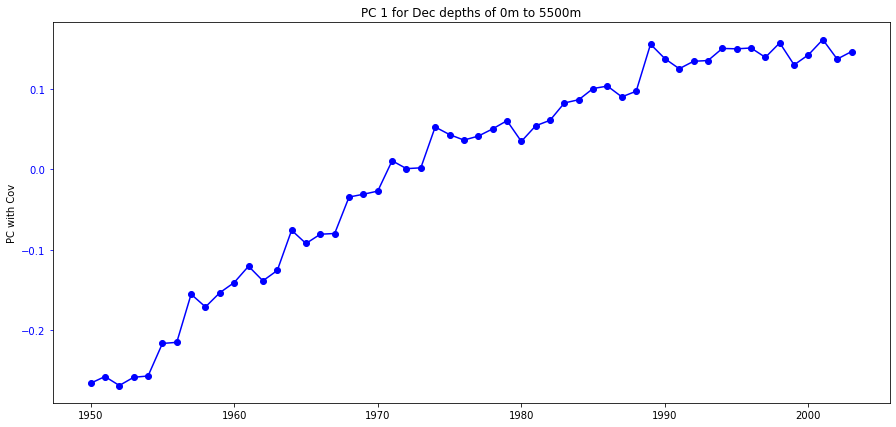

In [56]:
plt.figure(figsize=(15., 7.))
mode = 0
time = np.arange(1950,2004)

plt.plot(time, eigvecs[:,mode],'b', marker = 'o',label = 'PC with Cov')
plt.ylabel("PC with Cov")
plt.tick_params('y', colors='b')


plt.title('PC ' + str(mode+1)+' for '+month+' depths of 0m to ' + str(depths[tot_depths-1]) + 'm')
fig.set_size_inches(15., 7.)


# Scree Plot

In [57]:
num_eval = np.arange(eigvals.shape[0])+1

In [58]:
cumulative_eval = np.cumsum(eigvals)

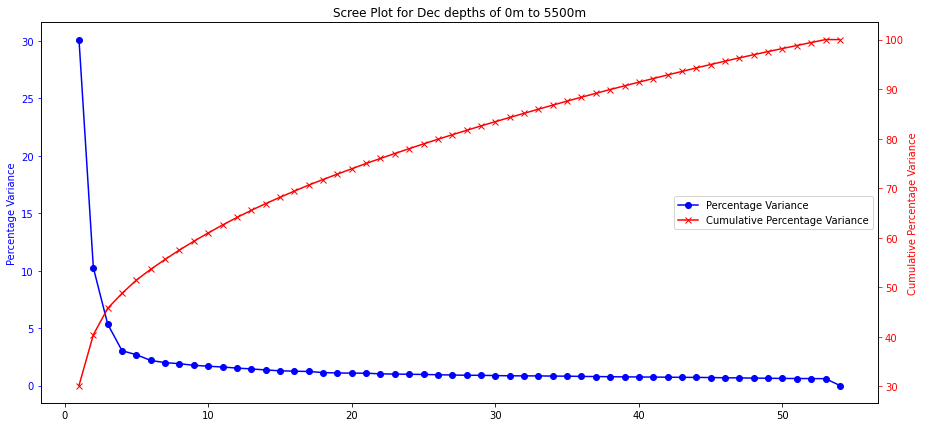

In [59]:
fig, ax = plt.subplots()


p1, = plt.plot(num_eval,(eigvals/cumulative_eval[-1])*100, 'b',marker = 'o',label = 'Percentage Variance')
ax.set_ylabel("Percentage Variance")
ax.yaxis.label.set_color('blue')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()
p2, = plt.plot(num_eval,(cumulative_eval/cumulative_eval[-1])*100,'r',marker = 'x',label = 'Cumulative Percentage Variance')
ax2.tick_params('y', colors='r')
ax2.set_ylabel("Cumulative Percentage Variance")
ax2.yaxis.label.set_color('red')

plt.legend(handles=[p1,p2],loc='center right')
plt.title('Scree Plot for '+month+' depths of 0m to ' + str(depths[tot_depths-1]) + 'm')
fig.set_size_inches(15., 7.)
#plt.savefig('/Users/danilafarga/Desktop/Thesis/3D_reconstruction/'+month+'/depth2000m/imgs/'+month+'_screePlot.png')

# Find EOF

### A*v

In [60]:
ev = eigvecs.T

In [61]:
EOFs = []
for j in range(Y):
    EOFs.append(np.matmul(weighted_A , ev[j].T))

In [62]:
EOF = np.array(EOFs)
EOF = np.squeeze(EOF)
EOF = EOF.T
EOF.shape

(2073600, 54)

### Find Magnitude and divide

Getting rid of NaN

In [63]:
na_rows = np.argwhere(np.isnan(EOF[:,0]) == False)
new_N = round(na_rows.shape[0])

In [71]:
EOF_no_NaN = np.empty((numrows.shape[0],Y))*np.nan
for i in range(numrows.shape[0]):
        EOF_no_NaN[i,:] = EOF[numrows[i,0],:]
EOF_no_NaN.shape

(1060928, 54)

In [72]:
mag = np.linalg.norm(EOF_no_NaN, axis = 0)

In [73]:
for i in range(Y):
    EOF[:,i] = EOF[:,i]/mag[i]

### Varifying Geometric EOFs

In [75]:
# Check to make sure vectors are orthogonal
# Make sure you are passing an array into this 
n, m = EOF_no_NaN.shape
for col_i in range(m):
    for col_j in range(m):
        if col_i < col_j:  # use strictly less than because we don't want to consider a column with itself, and the dot product is commutable so order doesn't matter
            is_orthogonal = np.dot(EOF_no_NaN[:, col_i], EOF_no_NaN[:, col_j])
            if not np.isclose(is_orthogonal, 0) and col_j != 53:
                pprint(f"EOF Mode {col_i} and EOF Mode {col_j} are not orthogonal.")
                pprint(np.dot(EOF_no_NaN[:, col_i], EOF_no_NaN[:, col_j]))
                

In [76]:
# checking magnitude of EOF. If magnitude is not 1 or close to 1 error will be raised
# Make sure you are passing an array into this 
for col_i in range(54):
    is_one = np.linalg.norm(EOF_no_NaN[:,col_i])
    if not np.isclose(is_one, 1):
        raise ValueError(f"EOF {col_i} does not have magnitude of one")

### STOP as long as the EOFs pass the last two tests you now have your geometric EOFs! These can be saved to any file you like

Now that  we have computed geometric EOFs we need to compute Physical EOFs by dividing by the volume weights. 

In [77]:
EOF = EOF/area_weight[:,0]

## Plot  Physical EOF

In [84]:
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [85]:
top2 = cm.get_cmap('winter', 128)
bottom2 = cm.get_cmap('hot_r', 128)

newcolors2 = np.vstack((top2(np.linspace(0, 1, 128)),
                    bottom2(np.linspace(0, .9, 128))))
newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')

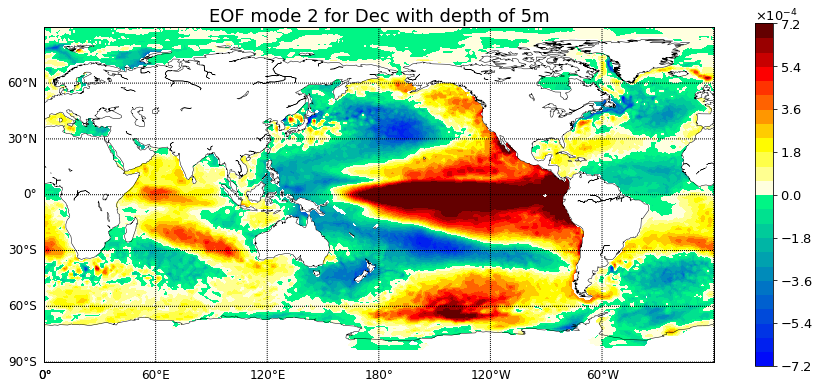

In [88]:
plt.figure(figsize=(15., 7.))
mymap = Basemap(projection='cyl', lon_0 = 180, lat_0 = 0)

x = linspace(0, 360, 360)
y = linspace(-90, 90, 180)

xx, yy = meshgrid(x, y)


mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()


mode = 1
depth_ind = 0
depth = depths[depth_ind]


EOF1 = np.reshape(-EOF[depth_ind *64800: (depth_ind+1) *64800, mode],(360,180))
clip = .0007

EOF1 = np.maximum(np.minimum(EOF1, clip), -clip)

mymap.contourf(xx, yy, EOF1.T, 25, cmap = newcmp2)

plt.title('EOF mode '+ str(mode+1) + ' for '+month+' with depth of ' + str(depth) + 'm', fontsize=18)

mymap.drawparallels(np.arange(-90,90,30), labels = [1,0,0,0],fontsize = 12)
mymap.drawmeridians(np.arange(-180,180,60), labels = [0,0,0,1],fontsize= 12)

cbar = plt.colorbar(shrink = .90, format = matplotlib.ticker.ScalarFormatter(useMathText=True))
cbar.ax.yaxis.get_offset_text().set_fontsize(13) # change exp size
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.tick_params(labelsize=13)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

plt.show()